# exploratory data analysis and data checking

In [1]:
#import system libraries
import os, errno, argparse

#import number-crunching libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from MYdata_methods import fill_and_upsample

/Users/dgrayson1/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#define inputs
designfile="test/subject_info_164.txt"
outdir="test/DQforIQ"

In [3]:
#make output directory
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

mkdir_p(outdir)

In [4]:
#load data
df=pd.read_table(designfile)
number_of_subjects=len(df)

#convert TCV units mm^3 to cm^3
df['TCV'] = df['TCV']/1000

#list different data-columns-of-interest here
metric = ['diagnosis', 'gender', 'age', 'TCV', 'IQ', 'ADOS_severity']

In [5]:
#define ASD and TYP groups separately here
TYPdata=df[df['diagnosis'] > 0]
ASDdata=df[df['diagnosis'] < 0]
print ("***********************************")
print ("******", len(TYPdata), "TYPs,", len(ASDdata), "ASDs ******")
print ("***********************************")

***********************************
****** 56 TYPs, 108 ASDs ******
***********************************


In [6]:
#loop through each metric and print mean & stdev for each group, ttest of group comparison
for mc in metric:
    asdmc=ASDdata[mc]
    typmc=TYPdata[mc]
    if mc == 'gender':
        print ("")
        print ("******", mc, "******")
        #print chi-square test for differences in gender distributions
        print ("%s percentage male: %6.3f" % ('ASD', np.mean(asdmc>0)))
        print ("%s percentage male: %6.3f" % ('TYP', np.mean(typmc>0)))
        obs = np.array([[np.sum(asdmc>0), np.sum(asdmc<0)], [np.sum(typmc>0), np.sum(typmc<0)]])
        chi2, p, dof, ex = stats.chi2_contingency(obs)
        print ('chi2(%s) = %6.3f, p = %6.4f' %  (dof, chi2, p))
    elif mc == 'diagnosis':
        continue
    else:
        print ("")
        print ("******", mc, "******")
        #print mean and stdev of data
        print ("%s mean (sd): %4.2f (%4.2f)" % ('ASD', np.mean(asdmc), np.std(asdmc)))
        print ("%s mean (sd): %4.2f (%4.2f)" % ('TYP', np.mean(typmc), np.std(typmc)))
        dof = len(TYPdata)+len(ASDdata)-2
        t, p = stats.ttest_ind(asdmc, typmc)
        print ('T(%s) = %6.3f, p = %6.4f' %  (dof, t, p))


****** gender ******
ASD percentage male:  0.824
TYP percentage male:  0.607
chi2(1) =  8.135, p = 0.0043

****** age ******
ASD mean (sd): 48.06 (9.52)
TYP mean (sd): 46.83 (10.42)
T(162) =  0.757, p = 0.4503

****** TCV ******
ASD mean (sd): 1209.79 (144.68)
TYP mean (sd): 1120.73 (133.79)
T(162) =  3.811, p = 0.0002

****** IQ ******
ASD mean (sd): 68.71 (17.12)
TYP mean (sd): 104.48 (10.88)
T(162) = -14.133, p = 0.0000

****** ADOS_severity ******
ASD mean (sd): 7.91 (1.76)
TYP mean (sd): 0.00 (0.00)
T(162) = 33.389, p = 0.0000


In [7]:
#define TYP-male, TYP-female, ASD-male, and ASD-female groups separately here
TYP_m_data=df[(df['diagnosis'] > 0) & (df['gender'] > 0)]
TYP_f_data=df[(df['diagnosis'] > 0) & (df['gender'] < 0)]
ASD_m_data=df[(df['diagnosis'] < 0) & (df['gender'] > 0)]
ASD_f_data=df[(df['diagnosis'] < 0) & (df['gender'] < 0)]
print ("")
print ("***********************************")
print ("******", len(TYP_m_data), "TYP males,", len(TYP_f_data), "TYP females,", len(ASD_m_data), "ASD males,", len(ASD_f_data), "ASD females ******")
print ("***********************************")

#name each group here
groupdata = {
    'TYP males' : TYP_m_data,
    'TYP females' : TYP_f_data,
    'ASD males' : ASD_m_data,
    'ASD females' : ASD_f_data,
}


***********************************
****** 34 TYP males, 22 TYP females, 89 ASD males, 19 ASD females ******
***********************************


In [8]:
#loop through each metric and print mean & stdev for each group, ttest of group comparison
for mc in metric:
    if mc == 'diagnosis' or mc == 'gender' or mc == 'ADOS_severity':
        continue
    else:
        print ("")
        print ("******", mc, "******")
        #print mean and stdev of data for each group
        for g in groupdata:
            meanval=np.mean(groupdata[g][mc])
            stdval=np.std(groupdata[g][mc])
            maxval=np.max(groupdata[g][mc])
            submax=groupdata[g].SubjectID[groupdata[g][mc]==maxval].values
            minval=np.min(groupdata[g][mc])
            submin=groupdata[g].SubjectID[groupdata[g][mc]==minval].values
            print ("%s mean (sd): %4.2f (%4.2f), max is %s with %4.2f, min is %s with %4.2f" % (g, meanval, stdval, submax, maxval, submin, minval))
            
        #compute t-tests of dignostic effect within each gender group
        print ("****** Tests of dignostic effect within each gender group ******")
        print ("T-test of TYP-male vs ASD-male")
        dof = len(TYP_m_data)+len(ASD_m_data)-2
        t, p = stats.ttest_ind(TYP_m_data[mc], ASD_m_data[mc])
        print ('T(%s) = %6.3f, p = %6.4f' %  (dof, t, p))
        print ("T-test of TYP-female vs ASD-female")
        dof = len(TYP_f_data)+len(ASD_f_data)-2
        t, p = stats.ttest_ind(TYP_f_data[mc], ASD_f_data[mc])
        print ('T(%s) = %6.3f, p = %6.4f' %  (dof, t, p))
        #compute t-tests of gender effect within each diagnostic group
        print ("****** Tests of gender effect within each diagnostic group ******")
        print ("T-test of TYP-male vs TYP-female")
        dof = len(TYP_m_data)+len(TYP_f_data)-2
        t, p = stats.ttest_ind(TYP_m_data[mc], TYP_f_data[mc])
        print ('T(%s) = %6.3f, p = %6.4f' %  (dof, t, p))
        print ("T-test of ASD-male vs ASD-female")
        dof = len(ASD_m_data)+len(ASD_f_data)-2
        t, p = stats.ttest_ind(ASD_m_data[mc], ASD_f_data[mc])
        print ('T(%s) = %6.3f, p = %6.4f' %  (dof, t, p))


****** age ******
TYP males mean (sd): 46.99 (10.70), max is ['102969-100_2'] with 71.40, min is ['108243-300'] with 27.80
TYP females mean (sd): 46.59 (9.96), max is ['107547-100_2'] with 63.90, min is ['108916-100'] with 30.00
ASD males mean (sd): 48.41 (9.47), max is ['106677-100_2'] with 75.80, min is ['108369-100'] with 28.50
ASD females mean (sd): 46.42 (9.59), max is ['108570-201_1'] with 65.00, min is ['109882-100'] with 29.50
****** Tests of dignostic effect within each gender group ******
T-test of TYP-male vs ASD-male
T(121) = -0.714, p = 0.4765
T-test of TYP-female vs ASD-female
T(39) =  0.053, p = 0.9583
****** Tests of gender effect within each diagnostic group ******
T-test of TYP-male vs TYP-female
T(54) =  0.138, p = 0.8904
T-test of ASD-male vs ASD-female
T(106) =  0.823, p = 0.4122

****** TCV ******
TYP males mean (sd): 1166.12 (102.26), max is ['108602-100_1'] with 1346.63, min is ['108678-100_1'] with 1000.72
TYP females mean (sd): 1050.58 (145.94), max is ['1076

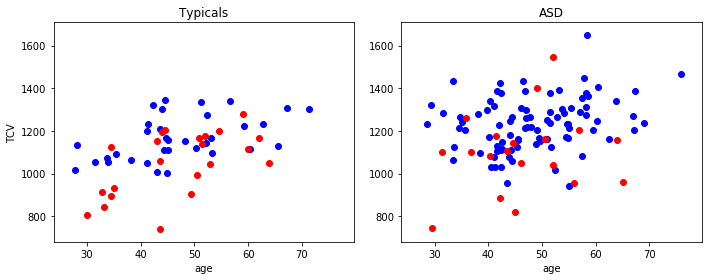

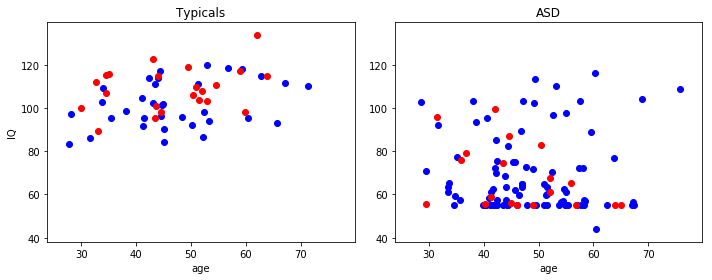

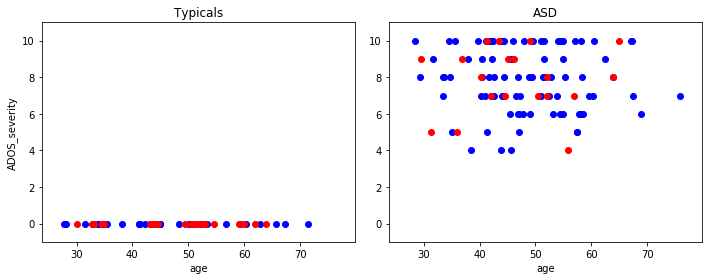

In [9]:
#define function to make plots
def makeplot(xax, yax, pdata, gr1data, gr2data, gr3data, gr4data):
    maxX=np.max(pdata[xax])
    minX=np.min(pdata[xax])
    marginX = np.ceil((maxX - minX) / 15.0)
    maxY=np.max(pdata[yax])
    minY=np.min(pdata[yax])
    marginY = np.ceil((maxY - minY) / 15.0)
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(gr1data[xax],gr1data[yax],'bo',gr3data[xax],gr3data[yax],'ro')
    plt.title('Typicals')
    plt.ylabel(yax);plt.xlabel(xax)
    plt.axis([minX - marginX,maxX + marginX,minY - marginY,maxY + marginY])
    plt.subplot(122)
    plt.plot(gr2data[xax],gr2data[yax],'bo',gr4data[xax],gr4data[yax],'ro')
    plt.title('ASD')
    plt.xlabel(xax)
    plt.axis([minX - marginX,maxX + marginX,minY - marginY,maxY + marginY])
    plt.tight_layout()
    plt.savefig(outdir + '/' + yax + 'info_' + str(number_of_subjects) + '.png', dpi=300)
    plt.show()
    
#make plots
makeplot('age', 'TCV', df, TYP_m_data, ASD_m_data, TYP_f_data, ASD_f_data)
makeplot('age', 'IQ', df, TYP_m_data, ASD_m_data, TYP_f_data, ASD_f_data)
makeplot('age', 'ADOS_severity', df, TYP_m_data, ASD_m_data, TYP_f_data, ASD_f_data)

# predicting diagnostic status based on brain connectivity

In [13]:
#load brain connectivity data
from scipy.io import loadmat
msubs = pd.read_table('test/SUBS_164_123maleids.txt',header=None,names=['connSubjects']) #ordered list of subject IDs in mat file
mconns = pd.read_csv('test/connection_names_scale33.csv',header=None) #ordered list of connections in mat file
mat = loadmat('test/123connectome_scale33_COM_ranknormal.mat') # load mat-file
mdata = mat['subject_array_2D'] # variable in mat file

In [14]:
#intersect connectivity subjects with larger dataframe
df2 = msubs.merge(df,left_on='connSubjects', right_on='SubjectID', how='inner')

In [15]:
#define function to regress out nuisance covariates from a feature
def regress(outcome, predictors):
    model = sm.OLS(outcome, predictors).fit()
    return model.resid

#regress age and TCV out from each connection
ageandTCV = sm.add_constant(df2.loc[:,['age', 'TCV']])
for col in range(0, len(mdata[1])):
    mdata[:,col] = regress(mdata[:,col],ageandTCV)

In [16]:
#prep variables for logistic regression
y = df2.diagnosis.copy()
y[y < 0] = 0 #ensure diagnosis is either 0 or 1, not -1 or 1
y = 1 - y #flip the 0 and 1 labels so that Autism is the positive class
#X = preprocessing.StandardScaler().fit_transform(mdata) #scale features
X = preprocessing.MinMaxScaler().fit_transform(mdata) #scale features

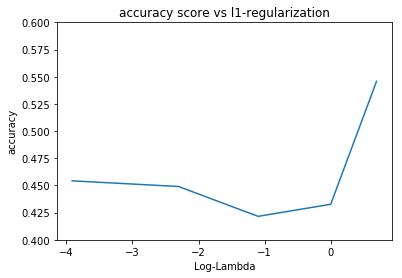

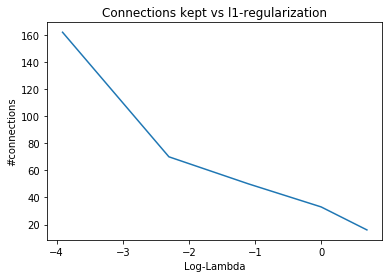

In [17]:
#regularized logistic regression with cross-validation
#try to find optimal or semi-optimal lambdas (inverse of C in sklearn)
numcrossvals = 5
#Rpar = np.array((50, 10, 5, 1, 0.5))
Rpar = np.array((50, 10, 3, 1, 0.5))
#Rpar = np.array([0])
regpenalty = "l1"
scoring = "accuracy"

def plot_logr_cvmetrics(X,y,numcrossvals,Rpar,regpenalty, plotme):
    scores=np.zeros((len(Rpar),numcrossvals))
    numcoeffs=np.zeros(len(Rpar))
    for i, C in enumerate(Rpar):
        #define the model
        clf = linear_model.LogisticRegression(C=C,class_weight="balanced",penalty=regpenalty, random_state=123)
        #clf = RandomForestClassifier(n_estimators=500, class_weight="balanced")
        
        #define the train/test splits
        skf = StratifiedKFold(n_splits = numcrossvals)
        
        #loop through the train/test splits, fitting model to training data and generating CV'ed scores w/ test data
        fold=0
        for train_index, test_index in skf.split(X, y):
            X_train_raw, X_test_raw = X[train_index], X[test_index]
            y_train_raw, y_test_raw = y[train_index], y[test_index]
            
            #upsample training set? (4th argument)
            X_train, y_train = fill_and_upsample(X_train_raw, y_train_raw, False, True)
            #upsample testing set? (4th argument)
            X_test, y_test = fill_and_upsample(X_test_raw, y_test_raw, False, True)
            
            #generate score for this fold
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
            if scoring == "precision": score = precision
            elif scoring == "recall": score = recall
            elif scoring == "f1": score = f1
            elif scoring == "accuracy": score = accuracy
            #append score to the scores matrix (regularization down rows, CV-folds across columns)
            scores[i,fold] = score
            fold+=1

        #scores[i,:] = cross_val_score(clf, X, y, cv=numcrossvals, scoring=scoring)
        
        logm = clf.fit(X, y)
        numcoeffs[i] = sum(logm.coef_.ravel()>0)
    
    if plotme == True:
        #for i in range(0, numcrossvals):
        #    plt.plot(np.log(1/Rpar),scores[:,i])
        plt.plot(np.log(1/Rpar),scores.mean(axis = 1))
        plt.title(scoring + ' score vs ' + regpenalty + '-regularization')
        plt.ylabel(scoring);plt.xlabel('Log-Lambda')
        plt.ylim(0.4,0.6)
        plt.show()
        plt.plot(np.log(1/Rpar),numcoeffs)
        plt.title('Connections kept vs ' + regpenalty + '-regularization')
        plt.ylabel('#connections');plt.xlabel('Log-Lambda')
        plt.show()
        
    return scores.mean(axis = 1) #return the mean scores (over the folds)

avg_obs_scores = plot_logr_cvmetrics(X,y,numcrossvals,Rpar,regpenalty, True)

In [49]:
avg_obs_scores

array([ 0.51666667])

/Users/dgrayson1/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


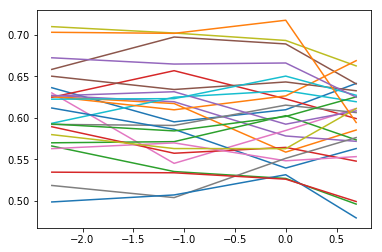

0.52
0.44


In [39]:
#plot observed-average-score relative to null-average-scores
num_perms = 25

def plot_null_logr_cvmetrics(X,y,numcrossvals,Rpar,regpenalty,num_perms):
    nullscores=np.zeros((num_perms,len(Rpar)))
    for n in range(num_perms):
        y = np.random.permutation(y)
        nullscores[n,:] = plot_logr_cvmetrics(X,y,numcrossvals,Rpar,regpenalty, False)
        plt.plot(np.log(1/Rpar),nullscores[n,:])
    plt.show()
    return nullscores

nullscores = plot_null_logr_cvmetrics(X,y,numcrossvals,Rpar,regpenalty,num_perms)

# this value reflects the p-value of the average score for the 1st regularization value
pval1 = sum(avg_obs_scores[0] < nullscores[:,0]) / float(len(nullscores[:,0]))

# this value reflects the p-value of the average score for the 2nd regularization value
pval2 = sum(avg_obs_scores[1] < nullscores[:,1]) / float(len(nullscores[:,1]))

print (pval1)
print (pval2)

In [89]:
#building the model with all the data for future predictions
logm = linear_model.LogisticRegression(C=1,class_weight="balanced",penalty="l1")
logm = logm.fit(X, y)
#predict labels
p = logm.predict(X)
#or probability estimates
p = logm.predict_proba(X)
#show the connections implicated
print mconns.T[logm.coef_.ravel()>0]

                                0                        1
169              rh.supramarginal      rh.inferiorparietal
209                  rh.precuneus                rh.cuneus
404                 rh.entorhinal      rh.inferiortemporal
769           rh.inferiortemporal        Right-Hippocampus
791   rh.rostralanteriorcingulate           Right-Amygdala
858          Right-Accumbens-area  lh.lateralorbitofrontal
899          Right-Accumbens-area         lh.parsorbitalis
984          Right-Accumbens-area   lh.medialorbitofrontal
1305                  rh.bankssts           lh.paracentral
2014                    lh.cuneus      lh.lateraloccipital
2075          lh.inferiorparietal               lh.lingual
2120               Right-Amygdala              lh.fusiform
2830          lh.isthmuscingulate     Left-Thalamus-Proper
2839                   lh.lingual     Left-Thalamus-Proper
2855           rh.parsopercularis             Left-Caudate
2888         Right-Accumbens-area             Left-Cauda